In [1]:
import torch
import torch.nn.functional as F
from torch import optim
import os
import matplotlib.image as img
import tqdm
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, TensorDataset

#### Create Dataset


In [2]:
cats = []
directory = "data/cats"
count = 0

for catpic in os.listdir(directory):
    if count < 1000:
        # read from image and convert to tensor
        im = torch.tensor(img.imread(os.path.join(directory, catpic))).float()
        # permute to (channels, height, width) for conv2d layer
        im = torch.permute(im, (2, 0, 1))
        # normalize to range between -1 and 1
        im = im / 128 - 1
        cats.append(im)
        count += 1
    else:
        break
cats = torch.stack(cats)
print(cats.shape)

torch.Size([1000, 3, 64, 64])


#### Test/Training/Validation Split


In [3]:
# Split the data into what we use for testing and not testing
training_test_split = 0.75
training_test_cutoff = int(cats.shape[0] * training_test_split + 1)
random_perm = torch.randperm(cats.shape[0])
not_test_tensor = cats[:training_test_cutoff]
testing_tensor = cats[training_test_cutoff:]
# Split the data into what we use for training and cross validation
training_cv_split = 0.8
training_cv_cutoff = int(not_test_tensor.shape[0] * training_cv_split)
training_tensor = not_test_tensor[:training_cv_cutoff]
cv_tensor = not_test_tensor[training_cv_cutoff:]
print(training_tensor.shape)
print(cv_tensor.shape)
print(testing_tensor.shape)

torch.Size([600, 3, 64, 64])
torch.Size([151, 3, 64, 64])
torch.Size([249, 3, 64, 64])


#### Choose Hyperparameters and Build Model


In [4]:
from vae import Basic_VAE

hidden_dims = [16, 32, 64, 128]
latent_dim = 64
in_dim = 3
model = Basic_VAE(in_dim, hidden_dims, latent_dim)
# encoder = Encoder(in_dim, hidden_dims, latent_dim) for testing
# decoder = Decoder(latent_dim, hidden_dims) for testing

In [5]:
# # Testing the model
model.forward(training_tensor)
# # Code to test out the encoder & decoder
# mu, log_var = encoder.forward(training_tensor)
# print("mu: ", mu.shape)
# print("log_var: ", log_var.shape)

# reconstructed_img = decoder.forward(mu, log_var)

[tensor([[[[-1.1441e-01,  1.8450e-01, -1.0022e-01,  ..., -1.0335e-01,
            -1.9757e-01, -8.4161e-02],
           [ 2.1961e-01,  3.1315e-01, -3.7766e-01,  ..., -1.8384e-01,
            -3.9726e-01, -6.9244e-02],
           [ 2.1431e-01, -1.5669e-01,  2.6540e-01,  ...,  7.2550e-02,
            -3.6948e-01,  1.2676e-01],
           ...,
           [-2.1865e-01, -7.0959e-02, -9.3127e-02,  ...,  1.1534e-01,
             1.1522e-01, -1.9321e-02],
           [-2.5447e-02, -1.2560e-01, -2.8188e-01,  ..., -8.1466e-02,
            -3.2245e-01, -4.8180e-02],
           [-1.0009e-01,  2.1743e-02,  1.3533e-02,  ..., -9.1875e-02,
             1.6719e-01, -1.3049e-02]],
 
          [[ 1.3386e-01, -6.3914e-02, -1.2176e-01,  ..., -2.0513e-01,
            -2.7175e-02, -1.4458e-01],
           [ 1.5360e-01,  7.8845e-02, -3.0234e-01,  ..., -1.4296e-02,
            -1.0424e-01, -1.4813e-01],
           [ 3.0746e-01,  1.9004e-01, -7.4113e-02,  ...,  7.1625e-02,
             1.4599e-01, -1.0515e-01],


#### Implement Loss Function


In [6]:
def loss_function(reconstructed_img, input_img, mu, log_var, kld_weight=0.001):
    # print("reconstructed_img: ", reconstructed_img.shape)
    # print("input_img: ", input_img.shape)
    img_loss = F.mse_loss(reconstructed_img, input_img)
    # article on calculating kl divergence between 2 gaussians:
    # https://medium.com/@outerrencedl/variational-autoencoder-and-a-bit-kl-divergence-with-pytorch-ce04fd55d0d7
    kld_loss = torch.mean(
        torch.sum(-log_var + (log_var.exp() ** 2 + mu**2) / 2 - 1 / 2)
        
    )
    # kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()))
    kld_loss *= kld_weight

    return img_loss + kld_loss

#### Implement Gradient Descent


In [7]:
def gradient_descent(model, loss_func, x, y, xvalid, yvalid, lr=0.001, steps=100, batch_size=32):
    # only really need x or y, they are the same thing
    optimizer = optim.AdamW(model.parameters(), lr)

    losses = []
    valid_losses = []

    train_dataset = TensorDataset(x, y)
    train_batches = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    valid_dataset = TensorDataset(xvalid, yvalid)
    valid_batches = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for _ in tqdm.trange(steps):
        model.train()
        total_loss = 0

        for input_batch, label_batch in train_batches:
            reconstructed_img, mu, log_var = model(input_batch)
            # y is the original image I think? yeah
            loss = loss_func(reconstructed_img, label_batch, mu, log_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            optimizer.zero_grad()
        mean_loss = total_loss/len(train_batches)
        losses.append(mean_loss)

        model.eval()
        total_valid_loss = 0
        for input_valid_batch, label_valid_batch in valid_batches:
            reconstructed_img, mu, log_var = model(input_valid_batch)
            valid_loss = loss_func(reconstructed_img, label_valid_batch, mu, log_var)
            total_valid_loss += valid_loss.detach()
        mean_valid_loss = total_valid_loss/len(valid_batches)
        valid_losses.append(mean_valid_loss)

    print(f"Final training loss: {losses[-1]}")
    print(f"Final validation loss: {valid_losses[-1]}")

    return losses, valid_losses

In [8]:
losses, valid_losses = gradient_descent(
    model, loss_function, training_tensor, training_tensor, cv_tensor, cv_tensor, steps=500, lr = 0.0001
)

100%|██████████| 500/500 [09:19<00:00,  1.12s/it]

Final training loss: 0.22038093836683975
Final validation loss: 0.19994470477104187


In [22]:
torch.save(model.state_dict(), "saved_model_1000img_300iter")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 64])
torch.Size([1, 3, 64, 64])


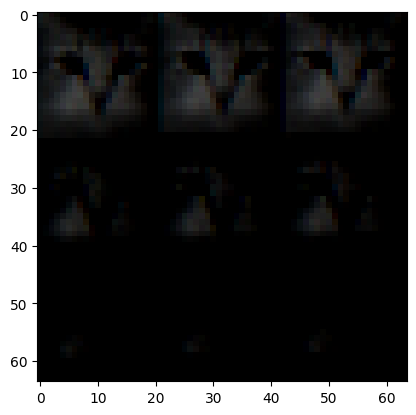

In [24]:
# after we've trained, we use the decoder to generate new images
# we assume a normal distribution over our latent space
# so we sample from that distribution and feed it into the decoder
img = model.sample_img()
print(img.shape)
img = img.view(64, 64, 3)
img = img.detach().numpy()
plt.imshow(img)

torch.Size([1, 3, 64, 64])
tensor([[[[206., 187., 206.,  ..., 116., 128.,  74.],
          [ 89.,  98.,  59.,  ..., 126., 115., 128.],
          [136., 104., 122.,  ..., 182., 184., 194.],
          ...,
          [144., 146.,  91.,  ..., 117., 207., 211.],
          [212., 211., 215.,  ..., 124., 141., 144.],
          [223., 203., 216.,  ..., 197., 200., 163.]],

         [[175., 177.,  85.,  ..., 181., 202., 206.],
          [207., 225., 229.,  ..., 140., 157., 160.],
          [218., 198., 210.,  ..., 213., 216., 196.],
          ...,
          [193., 201., 211.,  ...,  64.,  66.,  66.],
          [224., 210., 222.,  ..., 148., 158., 155.],
          [165., 175., 180.,  ..., 210., 216., 224.]],

         [[224., 229., 237.,  ..., 135., 140., 139.],
          [218., 204., 216.,  ..., 163., 173., 151.],
          [160., 170., 175.,  ..., 238., 197., 202.],
          ...,
          [222., 205., 216.,  ...,  91.,  99., 109.],
          [112., 117., 123.,  ..., 183., 146., 168.],
      

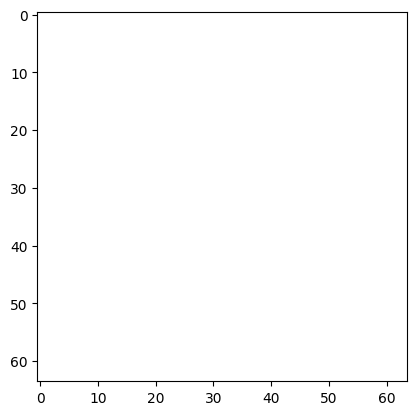

In [11]:
import cv2

img = cv2.imread("data/cats/3.jpg")
img = torch.from_numpy(img).float()
img = img.view(1, 3, 64, 64)
print(img.shape)
print(img)
rec_img = model.forward(img)[0]
print(rec_img)
rec_img = rec_img.view(64, 64, 3)
rec_img = rec_img.detach().numpy()
plt.imshow(rec_img)

In [25]:
# model1000 = model